<a href="https://colab.research.google.com/github/jose-marquez89/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [97]:
# get data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2019-12-11 00:25:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data.1’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.1s    

2019-12-11 00:25:28 (138 KB/s) - ‘house-votes-84.data.1’ saved [18171/18171]



In [98]:
# load data
df = pd.read_csv('house-votes-84.data', 
                 header=None,
                 names=['party', 'handicapped-infants', 'water-project',
                        'budget', 'physician-fee-freeze', 'el-salvador-aid',
                        'religious-groups', 'anti-satellite-ban', 
                        'aid-to-contras', 'mx-missile', 'immigration',
                        'synfuels', 'education', 'right-to-sue', 'crime', 'duty-free',
                        'south-africa'])
print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [99]:
# Replace question marks and yes/no values
df = df.replace({'?':np.NaN, 'n': 0, 'y':1})

df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [100]:
# separate the data into democrat and republican

# republicans
rep = df[df['party'] == "republican"]
print(f"Rep: {rep.shape}")

# democrats
dem = df[df['party'] == 'democrat']
print(f"Dem: {dem.shape}")

Rep: (168, 17)
Dem: (267, 17)


In [101]:
# clean this column for the example (especially graphic)
dem['anti-satellite-ban'] = dem['anti-satellite-ban'].fillna(method='bfill')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
# generate and numerically represent a confidence interval

def confidence_interval(data, confidence=0.95):
  mean = np.mean(data)
  n = len(data)
  sterr = (np.std(data, ddof=1) / np.sqrt(n))
  moe = sterr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - moe, mean + moe)

mean, low, high = confidence_interval(dem['anti-satellite-ban'])

# rounding for readability
roundLow = round(low, 2)
roundHigh = round(high, 2)

print("Confidence Interval: [%s-%s]" % (roundLow, roundHigh))

Confidence Interval: [0.72-0.83]


In [113]:
dem['anti-satellite-ban'].isnull().sum()

0

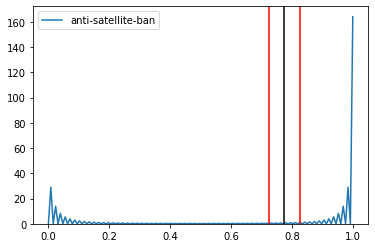

In [112]:
# graphically represent the confidence interval
sns.kdeplot(dem['anti-satellite-ban'])
plt.axvline(x=low, color='red')
plt.axvline(x=high, color='red')
plt.axvline(x=mean, color='k');


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


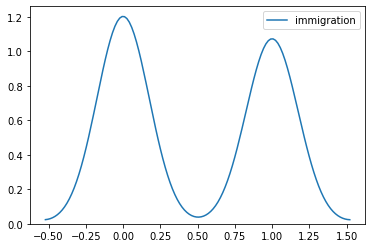

In [108]:
sns.kdeplot(dem['immigration'])

In [0]:
# get adult data set
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
adf = pd.read_csv(url, names=['age', 'workclass', 'fnlwgt', 'education', 
                              'education-num', 'marital-status', 'occupation',
                              'relationship', 'race', 'sex', 'capital-gain',
                              'capital-loss', 'hours-per-week', 'country', 'salary'])
adf.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [123]:
# crosstab
crosstab = pd.crosstab(adf['race'], adf['education'], margins=True)

crosstab

education,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college,All
race,,,,,,,,,,,,,,,,,
Amer-Indian-Eskimo,16,14,5,4,2,9,5,8,19,21,3,119,5,0,2,79,311
Asian-Pac-Islander,13,21,9,5,18,11,9,29,38,289,28,226,88,6,41,208,1039
Black,133,153,70,16,21,56,89,107,112,330,11,1174,86,5,15,746,3124
Other,9,10,14,9,13,17,8,8,6,33,2,78,7,2,4,51,271
White,762,977,335,134,279,553,403,915,1207,4682,369,8904,1537,38,514,6207,27816
All,933,1175,433,168,333,646,514,1067,1382,5355,413,10501,1723,51,576,7291,32561


In [133]:
# observed table
observed = pd.crosstab(adf['race'], adf['education'])
print(observed.shape)
observed

(5, 16)


education,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
race,,,,,,,,,,,,,,,,
Amer-Indian-Eskimo,16,14,5,4,2,9,5,8,19,21,3,119,5,0,2,79
Asian-Pac-Islander,13,21,9,5,18,11,9,29,38,289,28,226,88,6,41,208
Black,133,153,70,16,21,56,89,107,112,330,11,1174,86,5,15,746
Other,9,10,14,9,13,17,8,8,6,33,2,78,7,2,4,51
White,762,977,335,134,279,553,403,915,1207,4682,369,8904,1537,38,514,6207


In [132]:
# expected table

# get sums of rows and columns
row_sums = crosstab.iloc[0:5, 16].values
col_sums = crosstab.iloc[5, 0:16].values

# get sample size
total = crosstab.loc['All', 'All']

# calculate table of expected values
expected = []

for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column * row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)

expected = np.array(expected)

print(expected.shape)
expected

(5, 16)


array([[8.91136636e+00, 1.12227819e+01, 4.13571451e+00, 1.60461902e+00,
        3.18058413e+00, 6.17014219e+00, 4.90937011e+00, 1.01912411e+01,
        1.31999017e+01, 5.11472314e+01, 3.94468843e+00, 1.00298240e+02,
        1.64568963e+01, 4.87116489e-01, 5.50155094e+00, 6.96385553e+01],
       [2.97714137e+01, 3.74934738e+01, 1.38167440e+01, 5.36076902e+00,
        1.06258100e+01, 2.06134332e+01, 1.64014004e+01, 3.40472651e+01,
        4.40987070e+01, 1.70874512e+02, 1.31785572e+01, 3.35079973e+02,
        5.49797918e+01, 1.62737631e+00, 1.83797795e+01, 2.32650994e+02],
       [8.95148183e+01, 1.12733024e+02, 4.15433187e+01, 1.61184239e+01,
        3.19490188e+01, 6.19791775e+01, 4.93147016e+01, 1.02371180e+02,
        1.32593225e+02, 5.13774761e+02, 3.96244587e+01, 1.00749744e+03,
        1.65309788e+02, 4.89309296e+00, 5.52631676e+01, 6.99520408e+02],
       [7.76520991e+00, 9.77933724e+00, 3.60378981e+00, 1.39823715e+00,
        2.77150579e+00, 5.37655477e+00, 4.27793987e+00, 8.880

In [136]:
# make observed an array
observed = observed.values
print(observed.shape)
observed

(5, 16)


array([[  16,   14,    5,    4,    2,    9,    5,    8,   19,   21,    3,
         119,    5,    0,    2,   79],
       [  13,   21,    9,    5,   18,   11,    9,   29,   38,  289,   28,
         226,   88,    6,   41,  208],
       [ 133,  153,   70,   16,   21,   56,   89,  107,  112,  330,   11,
        1174,   86,    5,   15,  746],
       [   9,   10,   14,    9,   13,   17,    8,    8,    6,   33,    2,
          78,    7,    2,    4,   51],
       [ 762,  977,  335,  134,  279,  553,  403,  915, 1207, 4682,  369,
        8904, 1537,   38,  514, 6207]])

In [137]:
# numpy "by hand"
chi_squared = ((observed - expected)**2/(expected)).sum()
print(f"Chi-Squared with numpy: {chi_squared}")

Chi-Squared with numpy: 730.6712962254585


In [139]:
# scipy chi squared test
scipy_chi, p_value, dof, expected = stats.chi2_contingency(observed)


print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 730.6712962254585
P-value: 5.547319569858429e-116
Degrees of Freedom: 60
Expected: 
 [[8.91136636e+00 1.12227819e+01 4.13571451e+00 1.60461902e+00
  3.18058413e+00 6.17014219e+00 4.90937011e+00 1.01912411e+01
  1.31999017e+01 5.11472314e+01 3.94468843e+00 1.00298240e+02
  1.64568963e+01 4.87116489e-01 5.50155094e+00 6.96385553e+01]
 [2.97714137e+01 3.74934738e+01 1.38167440e+01 5.36076902e+00
  1.06258100e+01 2.06134332e+01 1.64014004e+01 3.40472651e+01
  4.40987070e+01 1.70874512e+02 1.31785572e+01 3.35079973e+02
  5.49797918e+01 1.62737631e+00 1.83797795e+01 2.32650994e+02]
 [8.95148183e+01 1.12733024e+02 4.15433187e+01 1.61184239e+01
  3.19490188e+01 6.19791775e+01 4.93147016e+01 1.02371180e+02
  1.32593225e+02 5.13774761e+02 3.96244587e+01 1.00749744e+03
  1.65309788e+02 4.89309296e+00 5.52631676e+01 6.99520408e+02]
 [7.76520991e+00 9.77933724e+00 3.60378981e+00 1.39823715e+00
  2.77150579e+00 5.37655477e+00 4.27793987e+00 8.88047050e+00
  1.15021652e+01 4.45688093e+01

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)